# How to Detect "Stop Signs" using Computer Vision 🛑
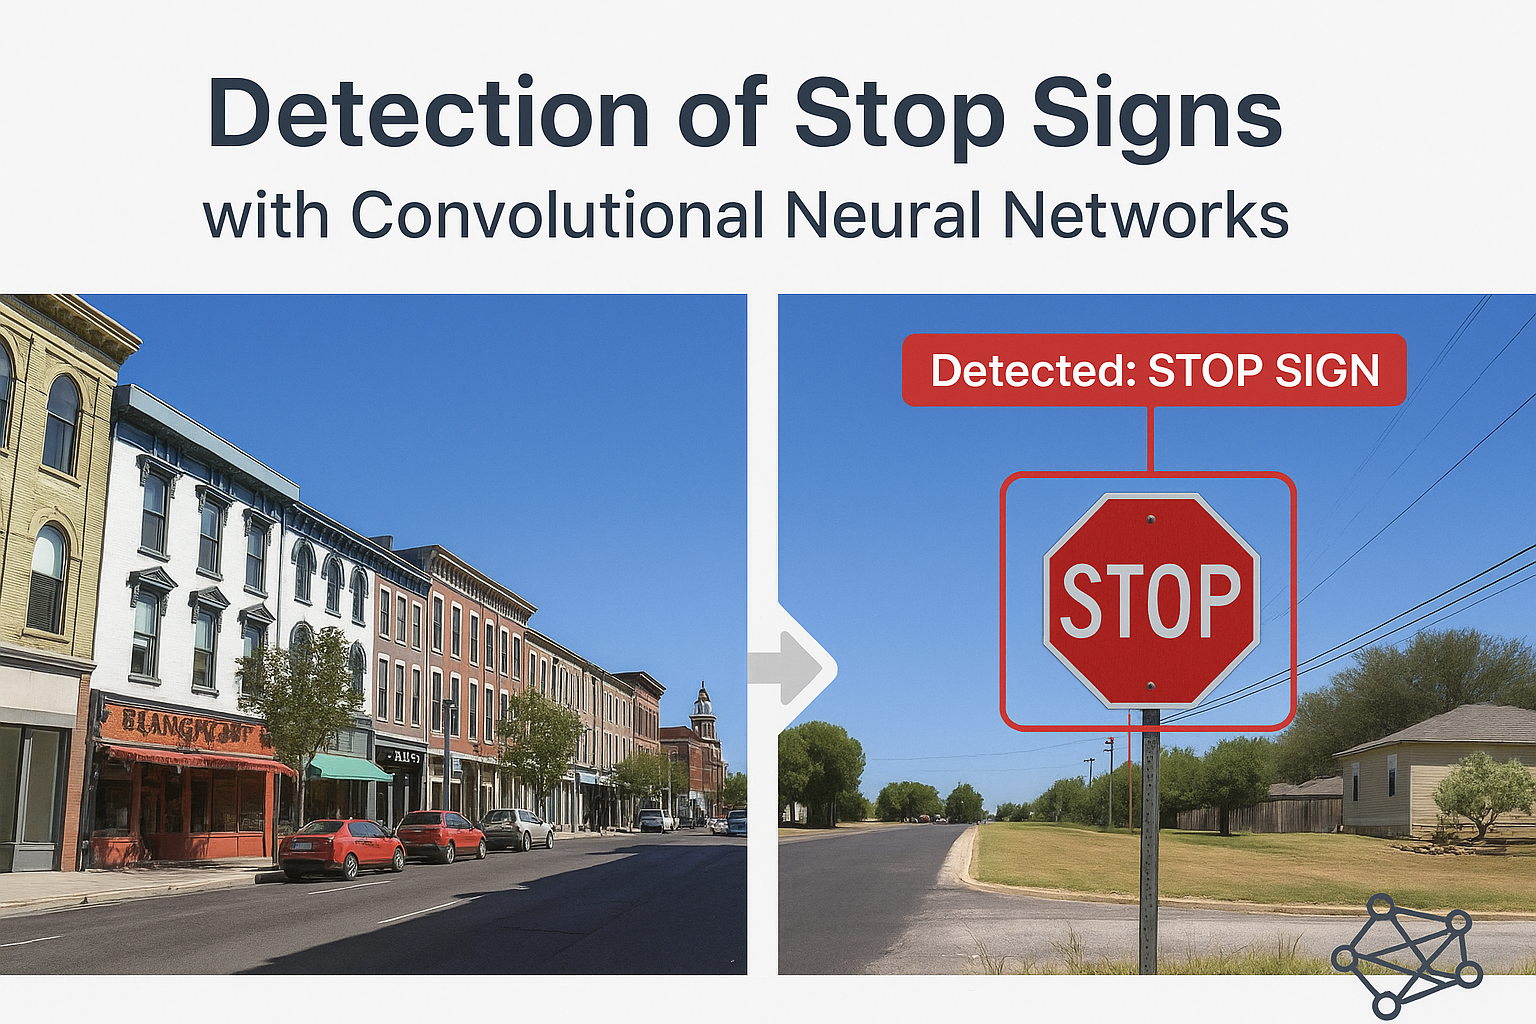
This notebook presents a tutorial and a solution for detecting *Stop* signs in traffic images using Deep Neural Networks with [Transfer Learning](https://cs231n.github.io/transfer-learning/). This application has the potential to be used in autonomous vehicles and intelligent transportation systems.

The development follows the structure below:
1. 🎯 Objective  
2. 🗂️ Data  
3. 🧠 Neural Network Construction
4. 💪 Neural Network Training  
5. 📈 Results Analysis

## 🎯 1. Objective
Train a Convolutional Neural Network (CNN) to detect *Stop* signs in traffic images.
The adopted methodology is based on *transfer learning*, since developing convolutional networks from scratch is generally not viable due to the lack of sufficiently large datasets. In this project, the pre-trained network will be used as a *feature extractor*, and only the output layer will be trained.
In general, between 100 and 200 images already provide a good starting point for applying *transfer learning*. The more images are used, the better the results tend to be — although this also requires longer training time.

### Importing Libraries


In [ ]:
# import system variables
import os
import copy
import json

# import EDA libraries
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# import Deep Learning libraries
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
import torch.nn as nn

# set a seed to ensure reproducibility
torch.manual_seed(0);

### Helper functions for image analysis


In [ ]:
def plot_images(img, label):
    """
    Plots a resized image with its corresponding class.

    Args:
      img (Tensor): Image in (C, H, W) format, as returned by the DataLoader.
      label (int): Class of the image (0 for 'not-stop-sign', 1 for 'stop-sign').
    """
    # resize the image
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    # dictionary for better label visualization
    dic = {0: 'not-stop-sign', 1: 'stop-sign'}
    plt.imshow(img)
    plt.title(f'y= {dic[label]}({label})')

In [ ]:
class StopSignDataset(Dataset):
    """
    Dataset personalizado para classificação de placas de 'Pare'.

    Cada instância do dataset representa uma imagem rotulada manualmente
    como contendo ou não uma placa de 'Pare'. O rótulo é fornecido
    diretamente na criação do objeto.

    Args:
        image_dir (str): Caminho para o diretório contendo as imagens.
        label (int): Rótulo associado a todas as imagens deste diretório
                     (0 = 'not-stop-sign', 1 = 'stop-sign').
        transform (callable, optional): Transformações a serem aplicadas às imagens.
    """
    def __init__(self, image_dir, label, transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.label

## 🗂️ 2. Data

The directory structure used to store the images is organized as follows:

```
/data
├── /test-stop-sign       # Folder containing test images
├── /stop-sign            # Folder containing images with stop signs
└── /not-stop-sign        # Folder containing images without stop signs
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define the image folder paths to simplify data handling
test_sign_path = '/content/drive/MyDrive/stop-sign-detection/data/test-stop-signs'
stop_sign_path = '/content/drive/MyDrive/stop-sign-detection/data/stop-signs'
not_stop_sign_path = '/content/drive/MyDrive/stop-sign-detection/data/not-stop-signs'

### 📦 2.1 Image Preprocessing

The images are resized to 224x224 pixels and converted to PyTorch tensors. This standardizes the input for the neural network and improves training performance.


In [ ]:
transform = transforms.Compose([
    # resize image
    transforms.Resize((224, 224)),
    # convert to tensor
    transforms.ToTensor()
])

### 🧾 2.2 Creating the Datasets
We create separate datasets for images with and without stop signs. Then, we merge them to form the complete training set.

In [ ]:
# Create separate datasets for each folder
stop_dataset = StopSignDataset(stop_sign_path, label=1, transform=transform)
not_stop_dataset = StopSignDataset(not_stop_sign_path, label=0, transform=transform)
test_dataset = StopSignDataset(test_sign_path, label=None, transform=transform)

In [ ]:
# merge the two datasets for training
train_dataset = ConcatDataset([stop_dataset, not_stop_dataset])

We split the training dataset into training and validation subsets, with 90% and 10%, respectively:


In [ ]:
# define the porcentage of train dataset
percentage_train = 0.90

# define the train and validation size
train_size = int(percentage_train * len(train_dataset))
val_size = len(train_dataset) - train_size

# define the train and validation dataset
train_set, val_set = random_split(train_dataset, [train_size, val_size])

test_set = test_dataset

Check the size of each set:

In [ ]:
print(f'Train set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')
print(f'Test set size: {len(test_set)}')

Train set size: 360
Validation set size: 40
Test set size: 12


### 🖼️ 2.3 Visualizing the Images
Below are some random samples from the validation set:

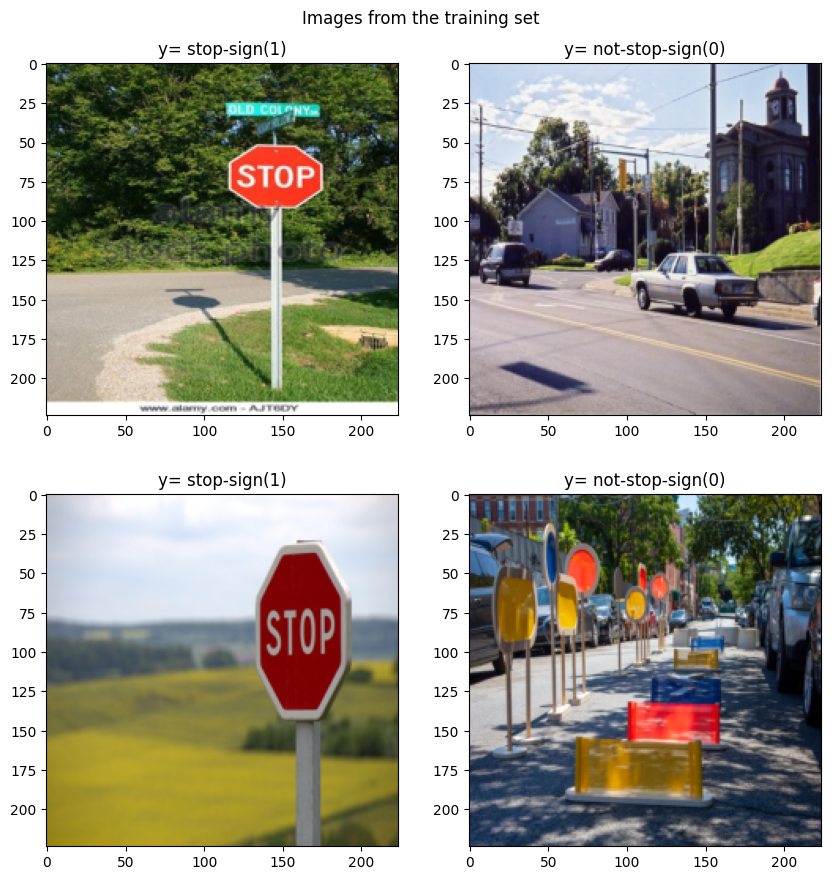

In [ ]:
i=0

plt.figure(figsize=(10, 10));
plt.suptitle("Images from the training set", y=0.95)

for x, y in val_set:
    i+=1

    plt.subplot(2, 2, i)
    plot_images(x, y)

    if i==4:
        break

plt.subplots_adjust(top=0.90)

## 🧠 3. Neural Network Construction

Building an effective neural network requires proper selection of **hyperparameters** and a robust **transfer learning** strategy. This project uses the **ResNet18** architecture — a lightweight and powerful network — as the base for an image classification model. Below, we detail the main components and technical decisions involved in the development process.

### 3.1 Hyperparameter Development

- **Epoch** indicates the number of passes over the entire training dataset. Here, we set the number of epochs to 10.
- **Batch size** is the number of training samples used in one iteration. A batch size between 32 and 512 tends to work well, balancing performance and gradient stability.
- **Learning rate** is a small positive hyperparameter, often between 0.0 and 1.0, that controls how much the weights are updated during training.
- **Momentum** is a term used in gradient descent to improve convergence and help avoid local minima.


#### 🔁 Epochs: 10
Represents the number of times the model will go through the entire training dataset. Ten epochs allow for good generalization without excessive [overfitting](https://aws.amazon.com/what-is/overfitting/).



In [ ]:
# define the num of epochs
n_epochs=10

#### 📦 Batch Size: 32
A moderate size that balances computational efficiency and gradient stability.

In [ ]:
# define the batch size
batch_size=32

#### 📉 Learning Rate: 0.000001
An extremely low value is used to ensure smooth weight updates since the pre-trained network is sensitive to large initial changes.


In [ ]:
#define the learning rate
lr=0.000001

#### 🌀 Momentum: 0.9
Adds inertia to the gradient descent, helping the model escape local minima and speeding up convergence.

In [ ]:
# define the moentum
momentum=0.9

#### 🔄 Learning Rate Scheduler: Enabled
We use a scheduler that adjusts the learning rate between `base_lr=0.001` and `max_lr=0.01` throughout training. This technique can significantly improve performance, accelerating early learning and refining it in later stages.  
If you set `lr_scheduler=True`, the learning rate will adjust each epoch, usually decaying over time.



In [ ]:
lr_scheduler=True
base_lr=0.001
max_lr=0.01

### 3.2 Neural Network Architecture: [ResNet18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)

ResNet18 was chosen because it's a well-established architecture trained on ImageNet that offers good accuracy with low complexity. We apply transfer learning by keeping the initial convolutional layers and replacing the final fully connected layer to fit our classification task.


In [ ]:
# load the pre-trained model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In [ ]:
# freeze the first 17 layers
for param in model.parameters():
    param.requires_grad = False

The number of classes is defined as:
- `not-stop-sign = 0`
- `stop-sign = 1`

In [ ]:
train_class = 2
train_class

2

We identify the number of input features in the model’s final layer and replace it with a new linear layer adapted to our binary classification problem.


In [ ]:
# get number of features
num_features = model.fc.in_features
num_features

512

In [ ]:
model.fc = nn.Linear(num_features, train_class)

## 💪 4. Treinamento da Rede Neural
We train our modified `ResNet18` model using PyTorch, leveraging transfer learning and cyclical learning rates for improved generalization.


### 4.1 Device selection
We check if a CUDA-capable GPU é disponivel para acelerar o treinamento do nosso modelo

In [ ]:
# escolhe a GPU para melhor eficacia no treinamento do modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.2 Model Training Functions


#### 4.2.1 Training a Single Epoch

This function trains the model for one epoch and returns the average loss.

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Trains the model for a single epoch.

    args:
      model: PyTorch model.
      train_loader: Training data loader.
      criterion: Loss function.
      optimizer: Optimizer.
      device: GPU or CPU

    returns:
      The average loss for the epoch.
    """
    # set model to training mode
    model.train()
    epoch_loss = []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # model makes predictions based on input data
        outputs = model(x)

        # Compute the loss by comparing the model's predictions with the true labels
        loss = criterion(outputs, y)

        # Compute the gradients of the loss with respect to the model's parameters
        loss.backward()

        # Update the model's weights using the optimizer and the computed gradients
        optimizer.step()

        # Store loss for analysis
        epoch_loss.append(loss.item())

    # Calcula e retorna a perda média (média das perdas de todas as iterações do batch)
    return np.mean(epoch_loss)

#### 4.2.2 Model Validation

This function evaluates the model's performance on a validation dataset, returning the average accuracy.


In [ ]:
def validate_model(model, validation_loader, device):
    """
    Validates the model on a validation set.

    args:
      model: PyTorch model.
      validation_loader: Validation data loader.
      device: GPU or CPU

    returns:
      Average accuracy on the validation set.
    """
    # Set model to evaluation mode
    model.eval()
    correct = 0
    total = 0

    # Disable gradient calculation for inference
    with torch.no_grad():
        for x, y in validation_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == y).sum().item()
            total += y.size(0)

    return correct / total

#### 4.2.3 Full Model Training Function

This function runs the complete training process across multiple epochs, keeping track of loss and accuracy, and saving the best model weights based on validation accuracy.


In [ ]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs, show_results=True):
    """
    Trains the model for a specified number of epochs.

    args:
      model: PyTorch model.
      train_loader: Training data loader.
      validation_loader: Validation data loader.
      criterion: Loss function.
      optimizer: Optimizer.
      n_epochs: Number of training epochs

    returns:
      accuracy_list: List of accuracy per epoch.
      loss_list: List of loss per epoch.
      model: Trained model.
    """
    # Save best model weights and accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    loss_list = []
    accuracy_list = []

    print("Starting training...")
    for epoch in tqdm(range(n_epochs)):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_accuracy = validate_model(model, validation_loader, device)

        # Update learning rate scheduler
        scheduler.step()

        # Log performance
        loss_list.append(train_loss)
        accuracy_list.append(val_accuracy)

        # Save best performing model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        if show_results:
            print(f"Epoch {epoch+1}/{n_epochs}")
            print(f"Loss: {train_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f}")
            print(f"LR: {optimizer.param_groups[0]['lr']}")

    # Load best weights before returning
    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model

### 4.3 Applying Transfer Learning
The model is transferred to the selected device (CPU or GPU).

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We use the *CrossEntropyLoss* function, which is suitable for classification tasks with multiple classes. It combines LogSoftmax and Negative Log Likelihood into a single loss function.


In [ ]:
criterion = nn.CrossEntropyLoss()

The `optim` package is used to define an optimizer that updates the model's weights during training.


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

### 4.4 Learning Rate Scheduler
We use [Cyclical Learning Rates](https://arxiv.org/pdf/1506.01186), which allow the learning rate to oscillate between a minimum and a maximum value during training, helping the model converge more effectively.



In [ ]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001,
                                                  max_lr=0.01,step_size_up=5,
                                                  mode="triangular2")

### 4.5 Dataloaders
We create `train_loader` and `validation_loader` objects to efficiently feed the model with training and validation data, using mini-batches and shuffling.


In [ ]:
# creates a training loader
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,shuffle=True)

# creates a validation loader
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)

### 4.6 Training the model
We run the training process using the defined configuration. For a dataset of 400 images, this takes around 5 minutes.


In [ ]:
accuracy_list,loss_list, model=train_model(model, train_loader,
                                           validation_loader, criterion,
                                           optimizer, n_epochs=n_epochs)

Starting training...


 10%|█         | 1/10 [00:52<07:54, 52.74s/it]

Epoch 1/10
Loss: 0.7175
Val Accuracy: 0.7000
LR: 0.002800000000000002


 20%|██        | 2/10 [01:00<03:32, 26.52s/it]

Epoch 2/10
Loss: 0.4204
Val Accuracy: 0.8750
LR: 0.0046


 30%|███       | 3/10 [01:10<02:10, 18.60s/it]

Epoch 3/10
Loss: 0.2549
Val Accuracy: 0.8750
LR: 0.006400000000000001


 40%|████      | 4/10 [01:18<01:28, 14.72s/it]

Epoch 4/10
Loss: 0.2717
Val Accuracy: 0.7500
LR: 0.008199999999999999


 50%|█████     | 5/10 [01:27<01:02, 12.46s/it]

Epoch 5/10
Loss: 0.1688
Val Accuracy: 0.9000
LR: 0.010000000000000002


 60%|██████    | 6/10 [01:36<00:44, 11.24s/it]

Epoch 6/10
Loss: 0.2451
Val Accuracy: 0.8250
LR: 0.008199999999999999


 70%|███████   | 7/10 [01:45<00:32, 10.73s/it]

Epoch 7/10
Loss: 0.1463
Val Accuracy: 0.8000
LR: 0.006400000000000001


 80%|████████  | 8/10 [01:54<00:19,  9.94s/it]

Epoch 8/10
Loss: 0.1727
Val Accuracy: 0.9250
LR: 0.0046


 90%|█████████ | 9/10 [02:03<00:09,  9.65s/it]

Epoch 9/10
Loss: 0.0741
Val Accuracy: 0.9000
LR: 0.002800000000000002


100%|██████████| 10/10 [02:11<00:00, 13.16s/it]

Epoch 10/10
Loss: 0.0691
Val Accuracy: 0.9250
LR: 0.001


### 4.7 Saving Results
We save the training metrics and hyperparameters to a JSON file and store the final model weights in a `.pth` file.


In [ ]:
parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum': momentum,
    'percentage_used_training': percentage_train,
    'learningRateScheduler': {
        'lr_scheduler': str(lr_scheduler),
        'base_lr': base_lr,
        'max_lr': max_lr
    },
    'accuracy': accuracy_list,
    'loss': loss_list
}

with open('/content/drive/MyDrive/stop-sign-detection/training_results.json', 'w') as f:
    json.dump(parameters, f, indent=4)

print("Results saved to training_results.json")

Results saved to training_results.json


Save model weights:

In [ ]:
# salva o modelo
torch.save(model.state_dict(), '/content/drive/MyDrive/stop-sign-detection/model.pth')

## 📈 5. Result Analysis

Reloading the trained model and plotting its learning curve and validation predictions.


### 5.1 Loading the Data

#### 5.1.1 Loading the Model and Weights


In [ ]:
# Load the pre-trained model and update the final fully connected layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(num_features, train_class)

# Load the model weights from the file
model.load_state_dict(torch.load("/content/drive/MyDrive/stop-sign-detection/model.pth"))

# Set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 5.1.2 Loading the Training Results


In [ ]:
# Load the training results (loss and accuracy) from a JSON file
with open('/content/drive/MyDrive/stop-sign-detection/training_results.json', 'r') as f:
    data = json.load(f)

# Extract the loss and accuracy data
loss_list = data['loss']
accuracy_list = data['accuracy']

### 5.2 Analyzing the Data


#### 📉 5.2.1 Plotting Loss and Accuracy


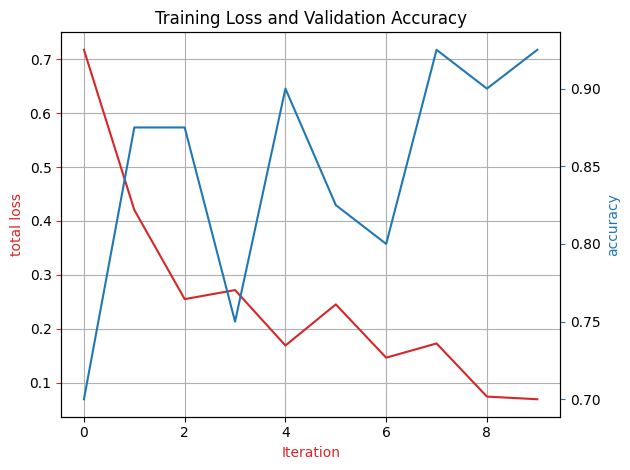

In [ ]:
# Create a figure with two y-axes: one for loss and another for accuracy
fig, ax1 = plt.subplots()

plt.title("Training Loss and Validation Accuracy")
# Plot training loss (using the first y-axis)
color = 'tab:red'
ax1.plot(loss_list, color = color)
ax1.set_xlabel('Iteration', color = color)
ax1.set_ylabel('total loss', color = color)
ax1.grid('on')
ax1.tick_params(axis = 'y', color = color)

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color = color)
ax2.plot(accuracy_list, color = color)
ax2.tick_params(axis = 'y', color = color)

fig.tight_layout()

#### 🖼️ 5.2.2 Model Predictions on Validation Set

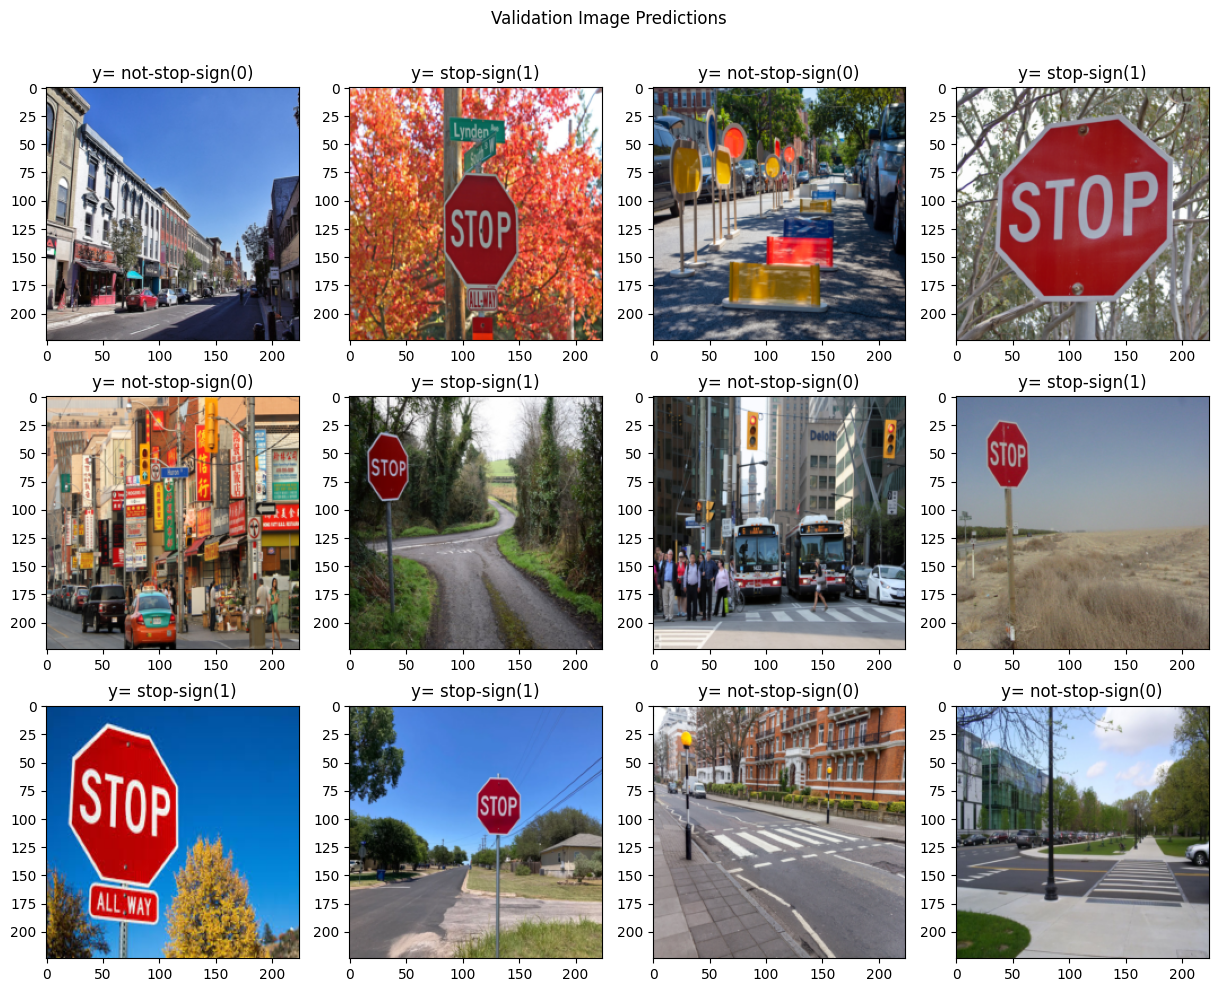

In [ ]:
# Plotting the predictions on validation images
plt.figure(figsize=(15, 15));
plt.suptitle("Validation Image Predictions", y=0.95)

# Initialize counter for subplot positions
i=0

for imageName in os.listdir(test_sign_path):
    # Open the image
    image = Image.open(f'{test_sign_path}/{imageName}')

    # Define the image transformation (resize and convert to tensor)
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor()])

    # Apply transformation to the image
    x = transform(image)

    # Make a prediction using the trained model
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)

    # Set the label based on the prediction
    prediction = "Not Stop"
    if yhat == 1:
        prediction ="Stop"

    # Increment the counter for subplot position
    i += 1

    # Plot the image with the prediction label
    plt.subplot(4, 4, i)
    plot_images(transform(image), yhat.item())


plt.subplots_adjust(top=0.90)

## 🙌 Credits

This notebook was developed by **[Lucas Lemos Ricaldoni](https://github.com/lemosslucas)** as part of an educational project on Computer Vision.
Inspired by real-world applications in autonomous vehicles and intelligent traffic systems.

🔧 Developed with: Python, PyTorch, Jupyter Notebook  
📅 May de 2025  

### Dataset Credit:
The dataset used in this project was provided by **IBM** as part of their Computer Vision course.